In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ndlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.2/110.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.8 MB/s eta 0:00:00


In [ ]:
import json
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from statsmodels.tsa.seasonal import seasonal_decompose
import collections
import itertools
import time
import math
from ndlib.models import epidemics
import ndlib.models.ModelConfig as config
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

In [ ]:
file_path = '/content/drive/MyDrive/merged_df.csv'
merged_df = pd.read_csv(file_path)

# **Epidemic models**

In [ ]:
def create_weighted_network(data):
    # Get all unique usernames
    unique_reviewerID = data.reviewerID.unique()

    # Assign a user ID to each unique username
    ids_to_reviewerID= {i: unique_reviewerID[i] for i in range(len(unique_reviewerID))}
    reviewerID_to_ids = dict((v,k) for k,v in ids_to_reviewerID.items())

    # Find all combinations of products
    df_combinations = data.groupby(["asin"])["reviewerID"].apply(list).reset_index(name="all_ids")

    # For all IDs in combinations, find all possible pariwise combinations of IDs.
    # These will be the edges found in the data
    df_combinations["edges"] = df_combinations["all_ids"].apply(lambda x: list(itertools.combinations(x, 2)))

    # combine all edges list into one
    edges_tuples = [j for i in df_combinations['edges'].tolist() for j in i]

    # Create graph adjancency matrix
    # Prepopulate matrix with zeroes
    A = np.zeros((len(unique_reviewerID), len(unique_reviewerID)))

    # Add all edges found.
    for edge in edges_tuples:
        id_0 = reviewerID_to_ids[edge[0]]
        id_1 = reviewerID_to_ids[edge[1]]
        A[id_0, id_1] += 1
        A[id_1, id_0] += 1
    # Create Graph
    G = nx.from_numpy_array(A)

    return df_combinations, edges_tuples, A, G, reviewerID_to_ids

In [ ]:
df_combinations, edges_tuples, A, G, ids_to_username = create_weighted_network(merged_df)

In [ ]:
print ("Number of nodes: %i" % nx.number_of_nodes (G))
print ("Number of edges: %i" % nx.number_of_edges (G))
print ("Number of connected components: %i" % nx.number_connected_components (G))
degree_sequence = [d for n, d in G.degree()]
mean_degree = sum (degree_sequence) / len (degree_sequence)
print ("Mean average degree: %i" % mean_degree)
avg_clustering_coeff = nx.algorithms.cluster.average_clustering(G)
print("Average clustering coefficient: {}".format(avg_clustering_coeff))
try:
    cycle = nx.find_cycle(G)
    print("Graph contains cycles, e.g. %s" % str(cycle))
except:
    print("Graph is a tree")

Number of nodes: 168037
Number of edges: 8591473
Number of connected components: 19500
Mean average degree: 102
Average clustering coefficient: 0.817821387433956
Graph contains cycles, e.g. [(0, 0)]


In [ ]:
isolated_nodes = nx.isolates(G)
isolated = []
for node in isolated_nodes:
    isolated.append(node)

len(isolated)

12387

In [ ]:
largest = max(nx.connected_components (G), key = len)
print("Number of nodes in largest component: %i" % len (largest))
component = G.subgraph(largest)
print ("Number of edges in largest component: %i" % nx.number_of_edges(component))
degree_sequence = [d for n, d in component.degree()]
mean_degree = sum (degree_sequence) / len (degree_sequence)
print ("Mean average degree in largest component: %i" % mean_degree)
avg_clustering_coeff = nx.algorithms.cluster.average_clustering(component)
print("Average clustering coefficient in largest component: {}".format(avg_clustering_coeff))

Number of nodes in largest component: 134408
Number of edges in largest component: 8519277
Mean average degree in largest component: 126
Average clustering coefficient in largest component: 0.9246331993010305


In [ ]:
# Assuming 'component' is the largest connected component of your network
diameter_approximation = nx.algorithms.approximation.diameter(component)

print("Approximate diameter of largest component: %i" % diameter_approximation)

Approximate diameter of largest component: 14


Text(0.5, 0, 'Degree')

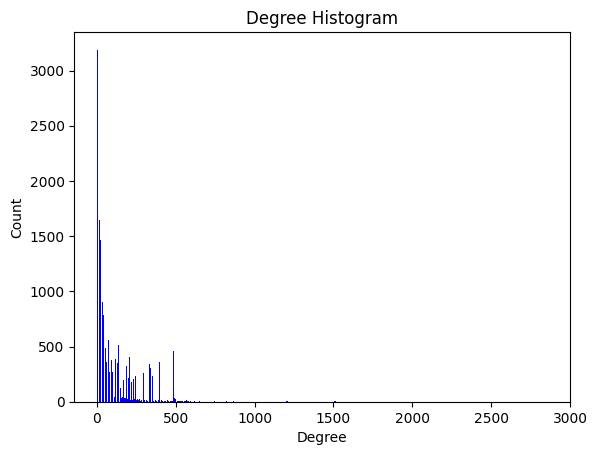

In [ ]:
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

fig, ax = plt.subplots()

plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

In [ ]:
pip install powerlaw

In [ ]:
import powerlaw

# Fit data to powerlaw
fit = powerlaw.Fit(np.array(degree_sequence)+1, xmin=1)

print(f"alpha = {fit.power_law.alpha}")  # This prints the exponent of the power law
print(f"xmin = {fit.power_law.xmin}")  # This prints the minimum value for which the power law holds
R, p = fit.distribution_compare('power_law', 'lognormal')
print(R)
print(p)

if p < 0.05:  # Null hypothesis rejection level
    print("The best fit is power law distribution")
else:
    print("The best fit is not power law distribution. The data is better explained by lognormal")

alpha = 1.2610145077694503
xmin = 1.0
-71221.78942611189
0.0
The best fit is power law distribution


In [ ]:
num_ocurs = {}

for edge in edges_tuples:
    if edge in num_ocurs:
        num_ocurs[edge] += 1
    elif (edge[1], edge[0]) in num_ocurs:
        num_ocurs[(edge[1], edge[0])] += 1
    else:
        num_ocurs[edge] = 1

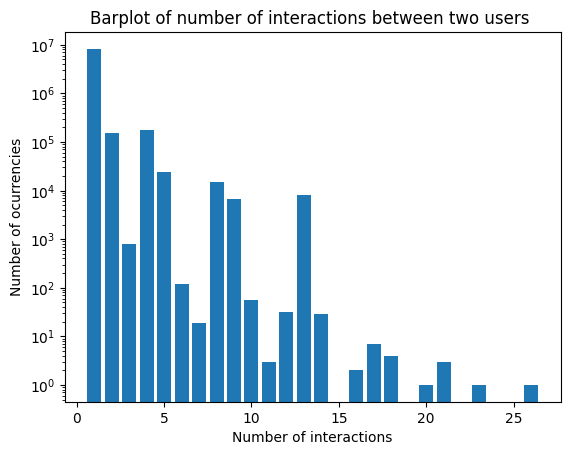

In [ ]:
#Create a list with all iteration values
lista_interacciones = list(num_ocurs.values())

counts = Counter(lista_interacciones)


plt.bar(list(counts.keys()), list(counts.values()))

plt.xlabel('Number of interactions')
plt.ylabel('Number of ocurrencies')
plt.yscale('log', base = 10)
plt.title('Barplot of number of interactions between two users ')
plt.show()

In [ ]:
counts = dict(sorted(counts.items()))
counts

{1: 8212934,
 2: 150944,
 3: 813,
 4: 172765,
 5: 24480,
 6: 121,
 7: 19,
 8: 14664,
 9: 6623,
 10: 57,
 11: 3,
 12: 32,
 13: 7970,
 14: 29,
 16: 2,
 17: 7,
 18: 4,
 20: 1,
 21: 3,
 23: 1,
 26: 1}

In [ ]:
sum_of_occurences = 0
i=0
while sum_of_occurences<0.998*sum(counts.values()):
    sum_of_occurences += list(counts.values())[i]
    mykey = list(counts.keys())[i]
    i+=1

In [ ]:
mykey

8

In [ ]:
A.shape

(168037, 168037)

In [ ]:
# Find indices where condition is met
indices = np.argwhere(A > 8)

# The indices array contain pairs (i, j), so we just flatten it to get the unique nodes
infected_nodes = np.unique(indices.flatten())

In [ ]:
# Create a dictionary mapping user IDs back to usernames
ids_to_reviewerID = dict((v,k) for k,v in ids_to_username.items())

# Convert infected nodes to usernames
infected_usernames = [ids_to_reviewerID[id] for id in infected_nodes]

# Filter original data for infected users
infected_data = merged_df[merged_df.reviewerID.isin(infected_usernames)]

# Check proportion of verified and unverified infected users
verified_infected = infected_data.verified.sum() / len(infected_data)
unverified_infected = 1 - verified_infected
print(f"Proportion of verified infected users: {verified_infected}")
print(f"Proportion of unverified infected users: {unverified_infected}")

Proportion of verified infected users: 0.9687827362245967
Proportion of unverified infected users: 0.031217263775403348


In [ ]:
value_counts = merged_df["verified"].value_counts()
proportions = value_counts / len(merged_df["verified"])
proportions

True     0.944984
False    0.055016
Name: verified, dtype: float64

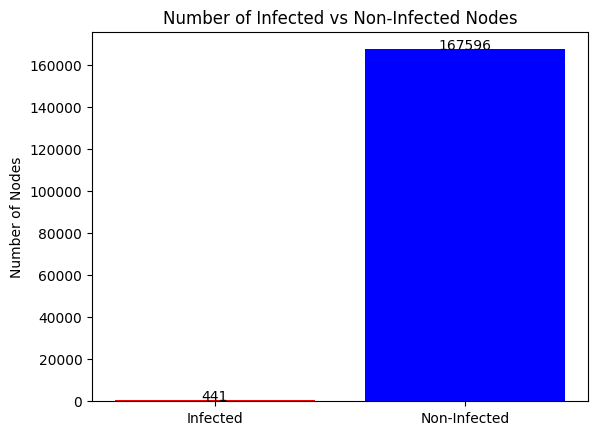

In [ ]:
# Count of infected and non-infected nodes
infected_count = len(infected_usernames)
non_infected_count = len(merged_df.reviewerID.unique()) - infected_count

# Labels
labels = ['Infected', 'Non-Infected']

# Counts
counts = [infected_count, non_infected_count]

# Create bar plot
plt.bar(labels, counts, color=['red', 'blue'])

# Adding text on bars
for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center')

plt.title('Number of Infected vs Non-Infected Nodes')
plt.ylabel('Number of Nodes')
plt.show()

In [ ]:
# Check category proportions among infected users
category_proportions = infected_data.main_cat.value_counts() / len(infected_data)
print("Proportions of categories amongst infected users:")
print(category_proportions)

Proportions of categories among infected users:
Musical Instruments    0.748167
Video Games            0.251624
Appliances             0.000210
Name: main_cat, dtype: float64


In [ ]:
value_counts = merged_df["main_cat"].value_counts()
proportions = value_counts / len(merged_df["main_cat"])
proportions

Musical Instruments    0.593442
Video Games            0.352754
Appliances             0.053803
Name: main_cat, dtype: float64

In [ ]:
# Filter original data for infected users
infected_data = merged_df[merged_df.reviewerID.isin(infected_usernames)]

# Get the ratings of the infected users
infected_ratings = infected_data['overall']

# Check the distribution of ratings
rating_distribution = infected_ratings.value_counts(normalize=True).sort_index()
print("Distribution of ratings amongst infected users:")
print(rating_distribution)

Distribution of ratings among infected users:
1.0    0.035827
2.0    0.020323
3.0    0.056568
4.0    0.118165
5.0    0.769118
Name: overall, dtype: float64


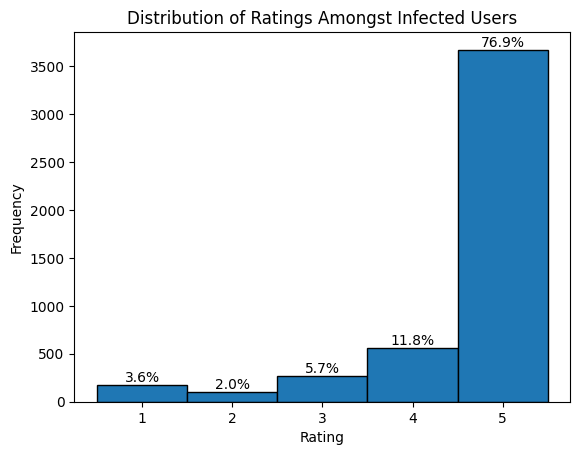

In [ ]:
# Plotting histogram with percentages
counts, bins, patches = plt.hist(infected_ratings, bins=np.arange(1,7)-0.5, edgecolor='black')

# Adding percentages on top of the bars
total = float(len(infected_ratings))
for patch, count in zip(patches, counts):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width()/2, height + 2,
             f'{100 * (count/total):.1f}%',
             ha='center', va='bottom')

plt.title("Distribution of Ratings Amongst Infected Users")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks(range(1,6))
plt.show()

In [ ]:
# Filter for non-infected users
non_infected_data = merged_df[~merged_df.reviewerID.isin(infected_usernames)]
non_infected_ratings = non_infected_data['overall']

# Perform a Mann-Whitney U test (does not assume normal distribution)
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(infected_ratings, non_infected_ratings)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=622476841.500, p=0.000


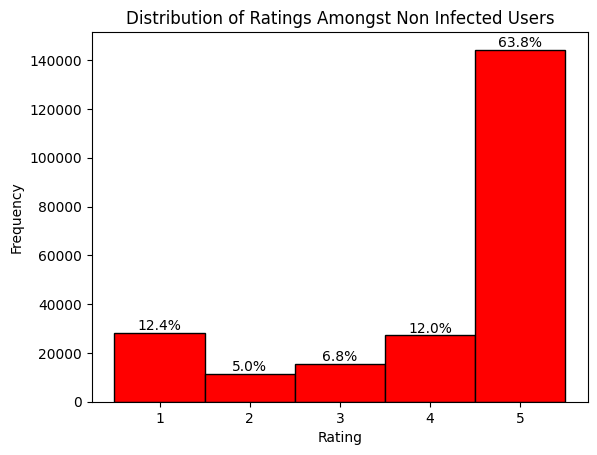

In [ ]:
# Plotting histogram with percentages
counts, bins, patches = plt.hist(non_infected_ratings, bins=np.arange(1,7)-0.5, edgecolor='black', color = "red")

# Adding percentages on top of the bars
total = float(len(non_infected_ratings))
for patch, count in zip(patches, counts):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width()/2, height + 2,
             f'{100 * (count/total):.1f}%',
             ha='center', va='bottom')

plt.title("Distribution of Ratings Amongst Non Infected Users")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks(range(1,6))
plt.show()

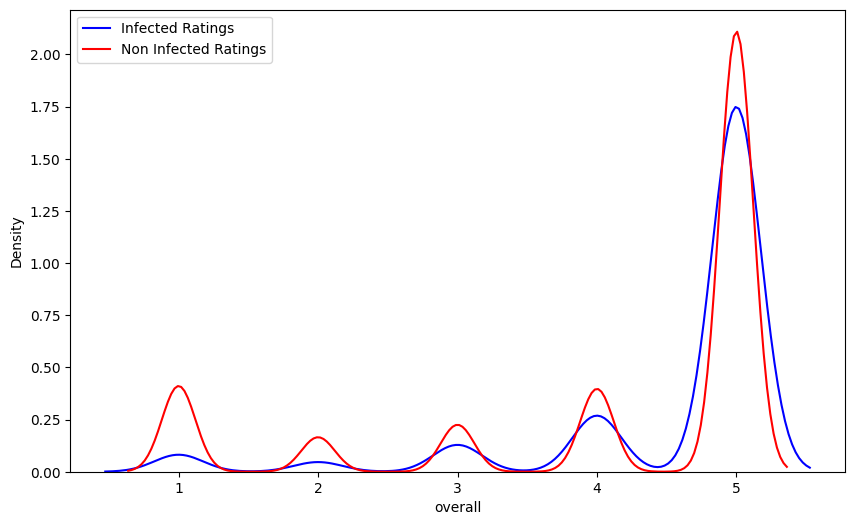

In [ ]:
plt.figure(figsize=(10,6))

sns.kdeplot(infected_ratings, color='blue', label='Infected Ratings')
sns.kdeplot(non_infected_ratings, color='red', label='Non Infected Ratings')

plt.legend()
plt.show()

In [ ]:
model_c = ep.ThresholdModel(G)

# set the initial status with the infected nodes
config_c = mc.Configuration()
config_c.add_model_initial_configuration("Infected", infected_nodes)
for node in G.nodes():
    config_c.add_node_configuration("threshold", node, 0.9)
model_c.set_initial_status(config_c)

iterations_c = model_c.iteration_bunch(30)
trends_c = model_c.build_trends(iterations_c)

no display found. Using non-interactive Agg backend


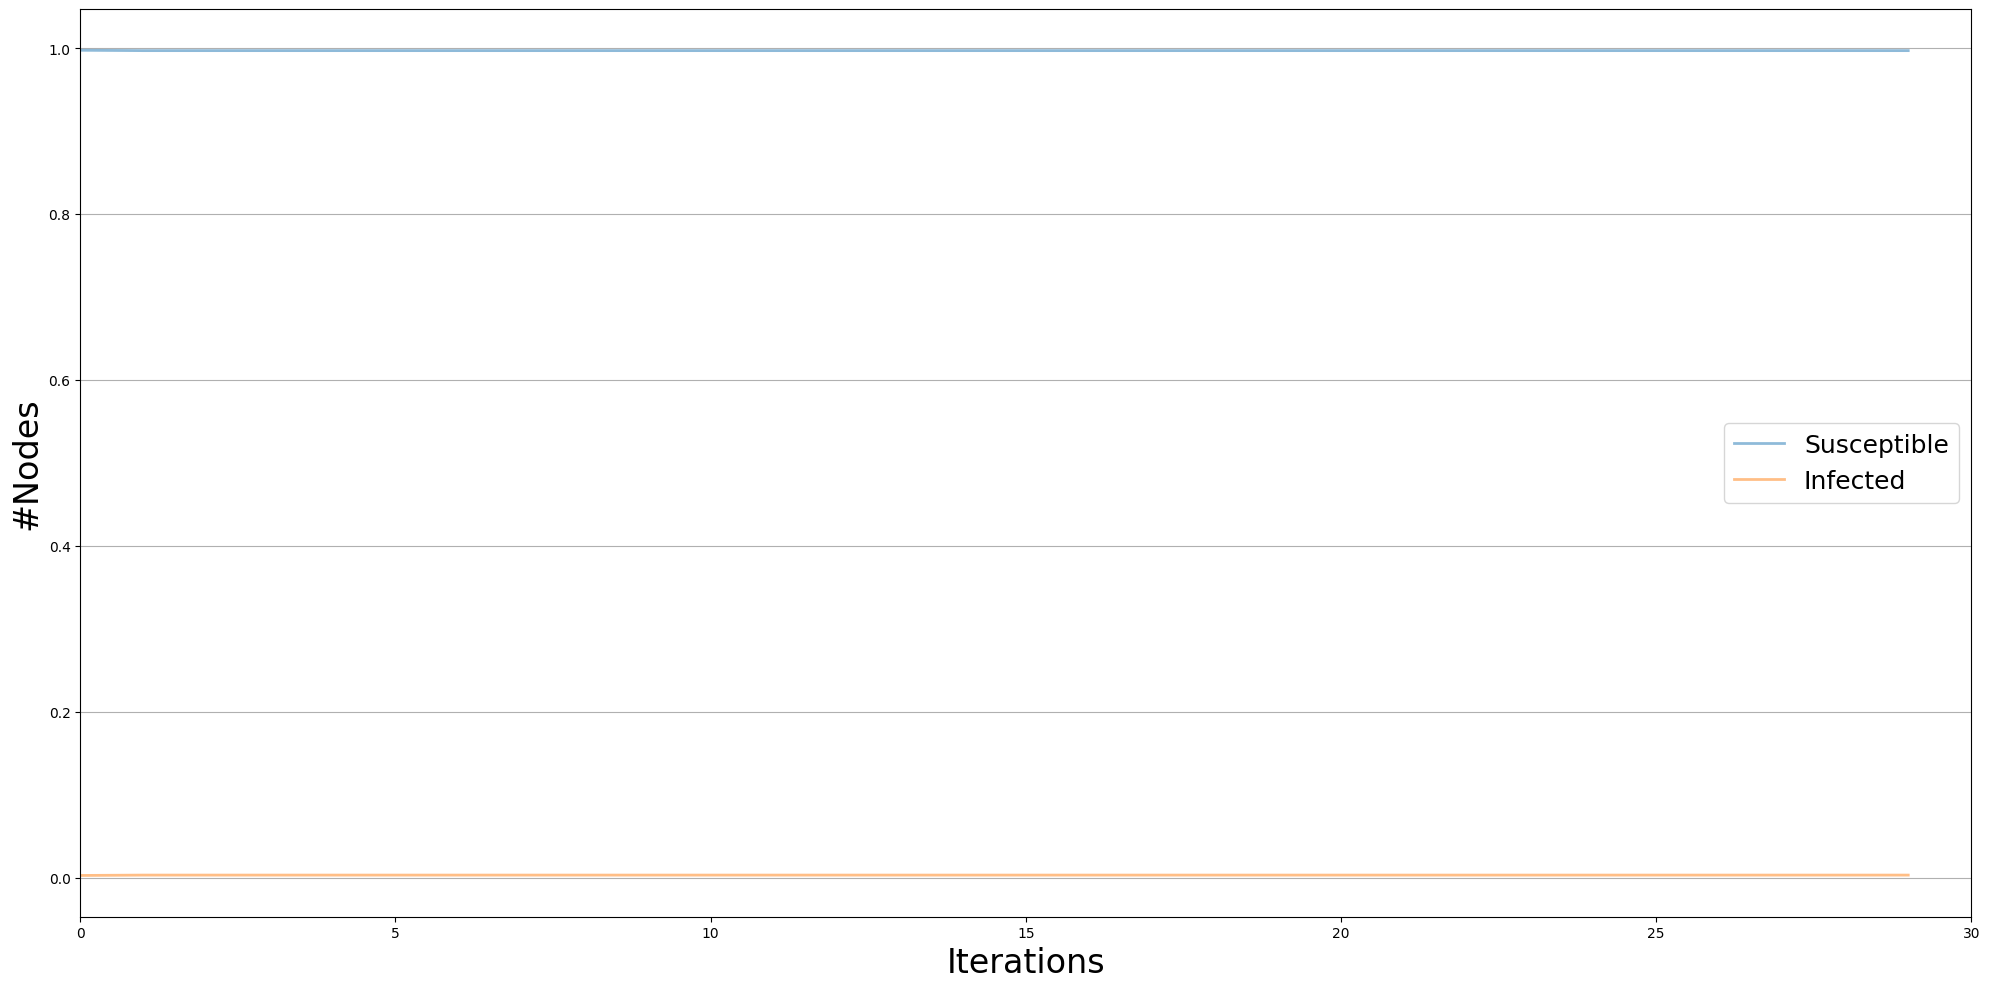

In [ ]:
# First, you should import the necessary libraries
import matplotlib.pyplot as plt
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

# Assuming you have already created your model_c and trends_c
%matplotlib inline
viz = DiffusionTrend(model_c, trends_c)
viz.plot()

plt.show()

In [ ]:
model_d = ep.ThresholdModel(G)

# set the initial status with the infected nodes
config_d = mc.Configuration()
config_d.add_model_initial_configuration("Infected", infected_nodes)
for node in G.nodes():
    config_d.add_node_configuration("threshold", node, 0.1)
model_d.set_initial_status(config_d)

iterations_d = model_d.iteration_bunch(40)
trends_d = model_d.build_trends(iterations_d)

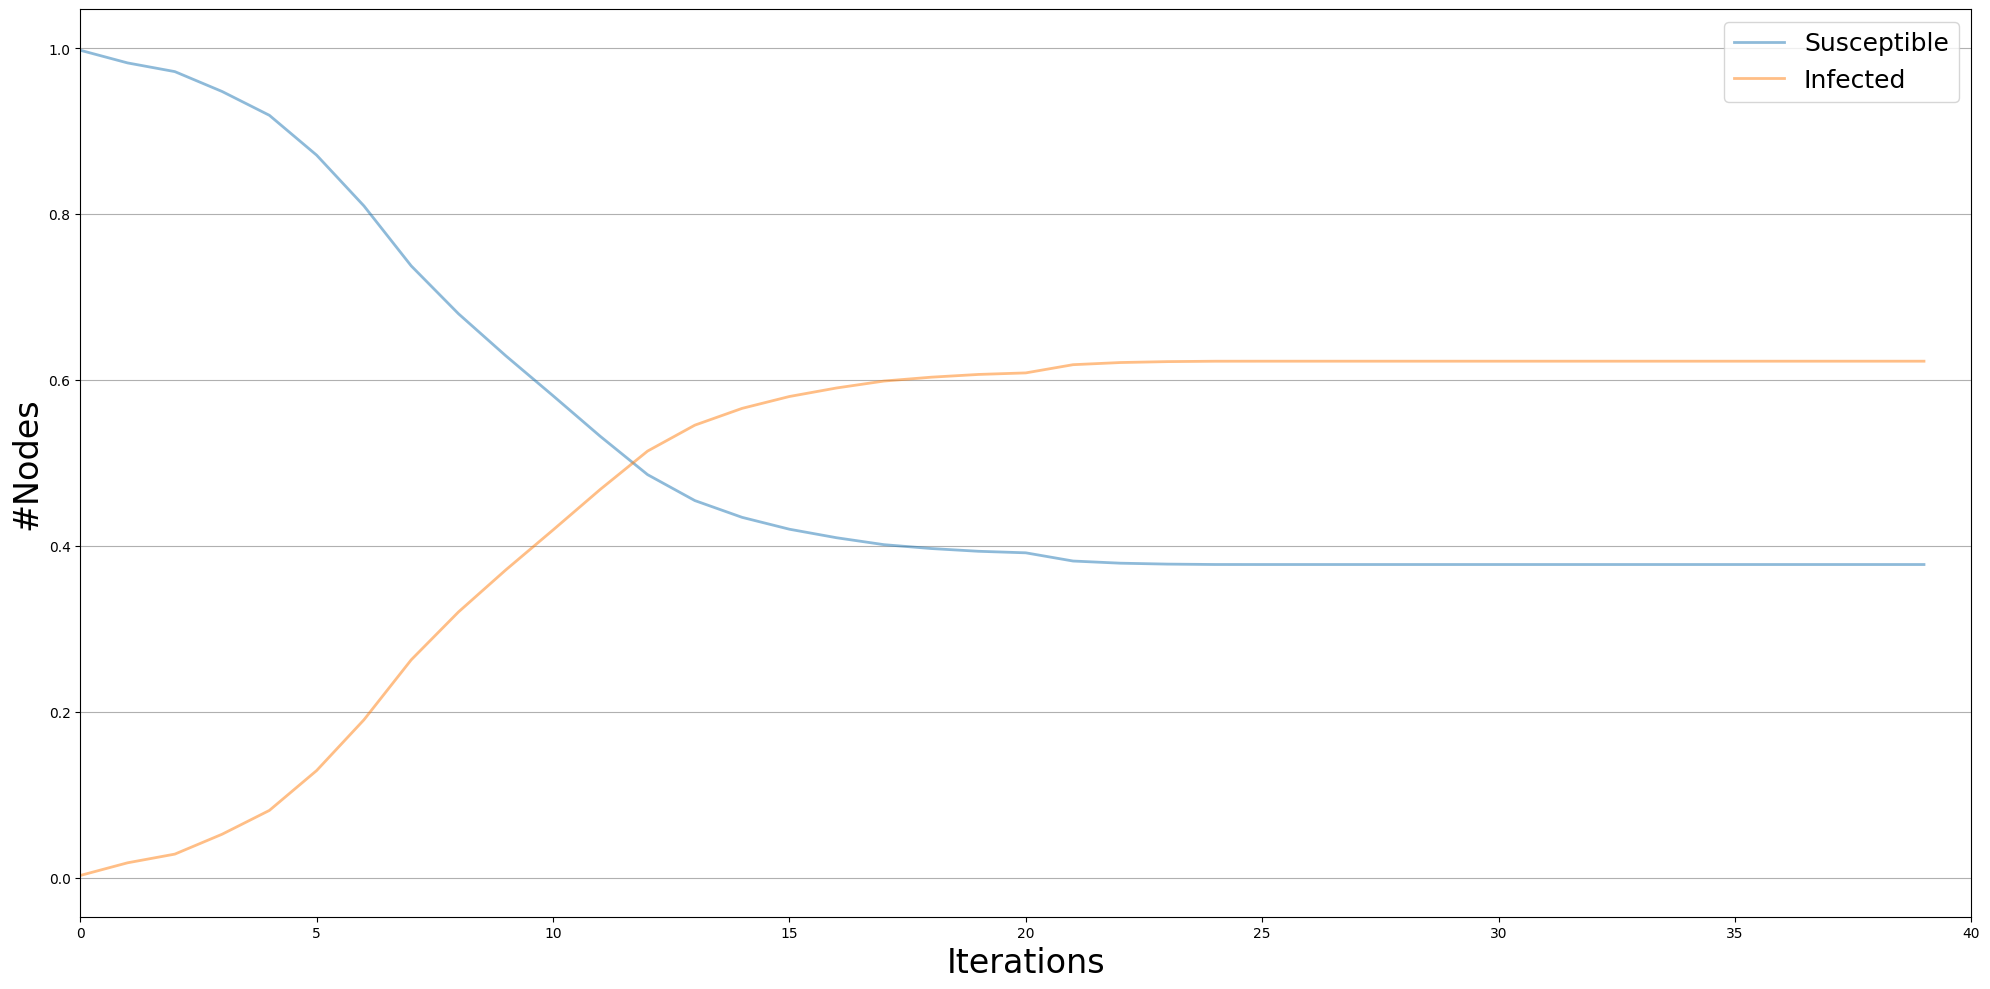

In [ ]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model_d, trends_d)
viz.plot()

In [ ]:
model_e = ep.ThresholdModel(G)

# set the initial status with the infected nodes
config_e = mc.Configuration()
config_e.add_model_initial_configuration("Infected", infected_nodes)
for node in G.nodes():
    config_e.add_node_configuration("threshold", node, 0.5)
model_e.set_initial_status(config_e)

iterations_e = model_e.iteration_bunch(30)
trends_e = model_c.build_trends(iterations_e)

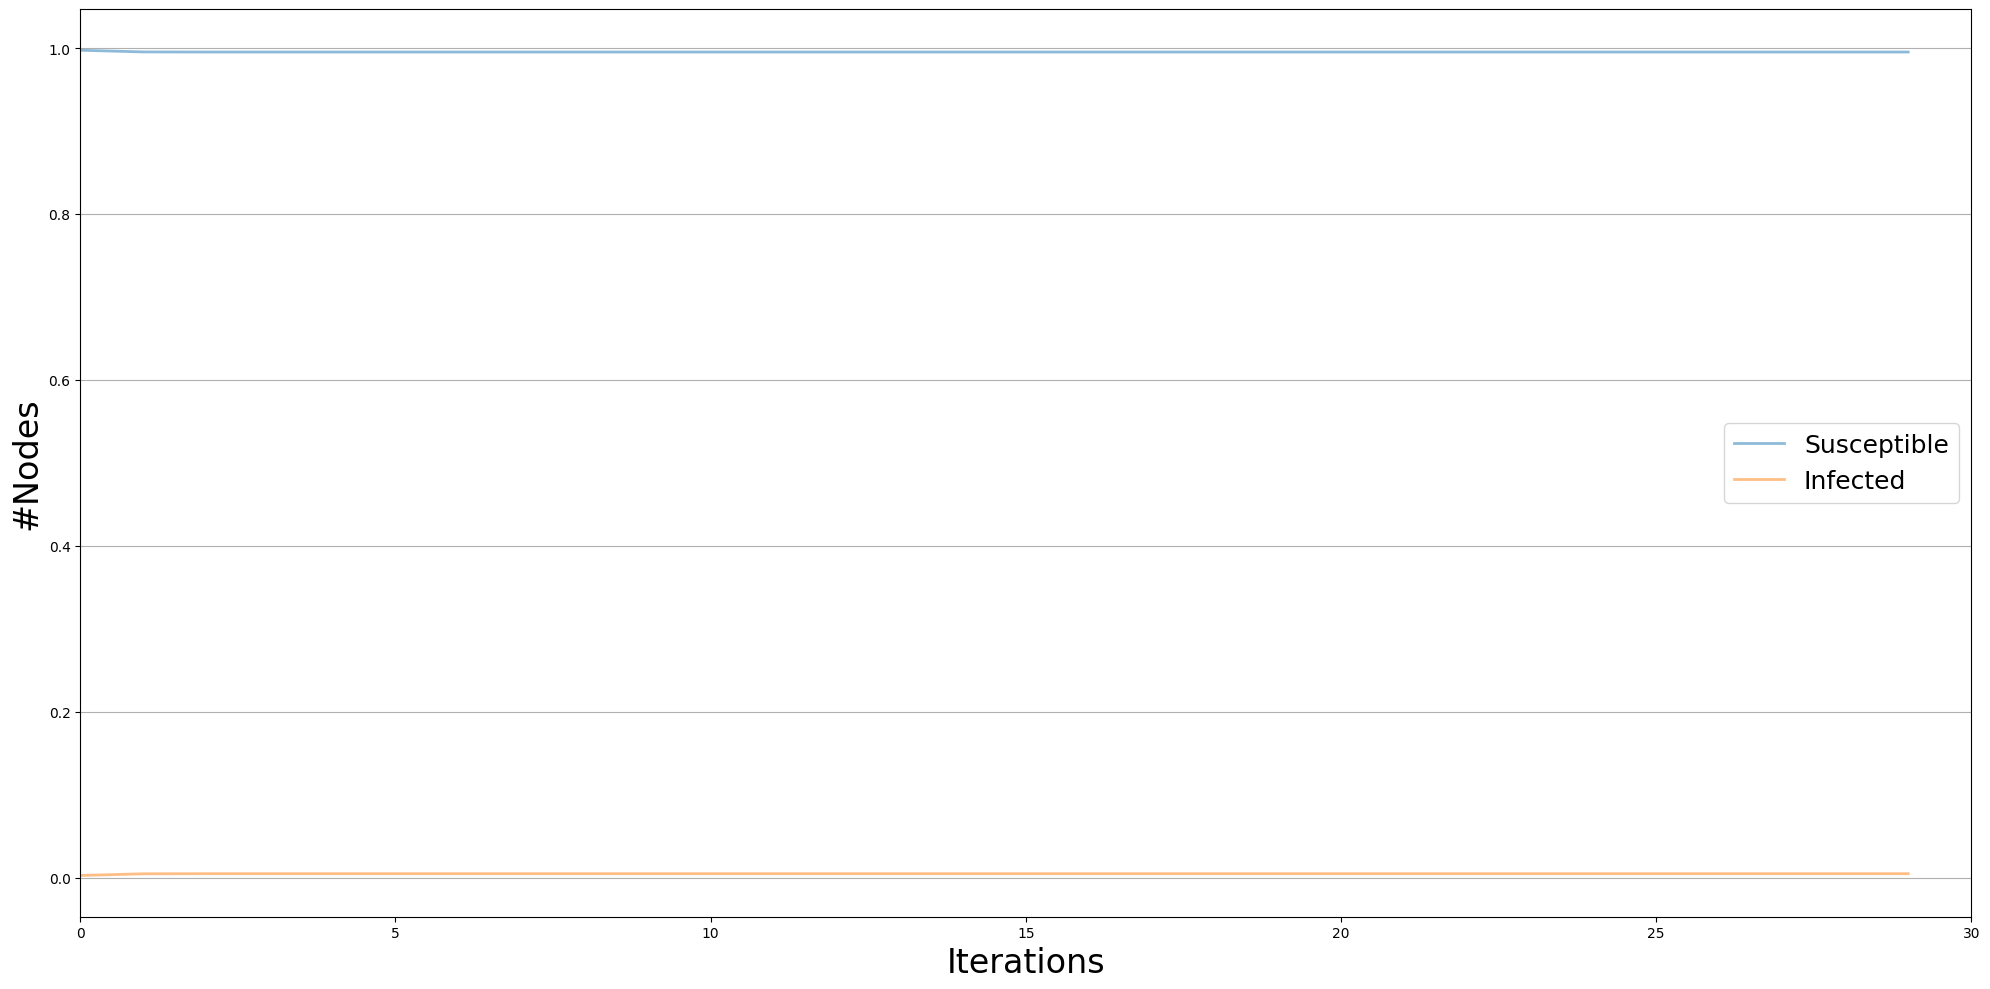

In [ ]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model_e, trends_e)
viz.plot()

In [ ]:
len(infected_nodes)/nx.number_of_nodes(G)

0.002624422002297113